In [1]:
import degirum as dg, degirum_tools
import os
from pathlib import Path
import gen_test_image_util as imgutil
import importlib
import os
import time
import cv2
#importlib.reload(imgutil)

In [2]:
#hw_location = "@cloud"
hw_location = "@local"
model_zoo_url = "https://cs.degirum.com/degirum/public"
#model_zoo_url = "https://cs.degirum.com/degirum/ultralytics_v6"
device_family = "ORCA1"  # models of which device family to use
exclude_preprocessing = True
use_jpeg = True

image_dir = Path('/home/gotom/data_dir/split_pic')

max_count = 3000

In [9]:
# draw_graph()
import matplotlib.pyplot as plt
    
def draw_graph(data_dir, duration1D, duration2D, label1, label2, graph_title, y_max, suffix):
    
    image_sizeL = []
    duration1L = []
    duration2L = []
    
    for k, v in duration1D.items():
        image_sizeL.append(k) 
        duration1L.append(v)
    
    for k, v in duration2D.items():
        duration2L.append(v)

    #fig = plt.figure()
    #ax1 = fig.add_subplot(111)
    fig, ax1 = plt.subplots(figsize = (16,6))
    
    plt.rcParams["font.family"] = "Dejavu Serif"
    plt.rcParams["font.size"] = 14
    plt.rcParams["lines.linewidth"] = 1.5
    plt.grid()
    
    font = {'family' : 'Dejavu Serif',
            'size' : 14,
    }

    ax1.set_ylim(0, y_max)
    #plt.xticks[x, model_symbolsL]
    x = image_sizeL
    
    ax1.plot(x, duration1L, color = 'lightblue', label = label1, marker = 'D', markersize = 4, 
             markeredgewidth = 1.5, markeredgecolor = 'skyblue', markerfacecolor = 'lightblue')
    
    for i, value in enumerate(duration1L):
        ax1.text(x[i], duration1L[i], value, size = 10, ha = 'right', va = 'top', color = 'black')
    
    ax1.plot(x, duration2L, color = 'yellowgreen', label = label2, marker = 'D', markersize = 4, 
              markeredgewidth = 1.5, markeredgecolor = 'lime', markerfacecolor = 'yellowgreen')
    
    for i, value in enumerate(duration2L):
         ax1.text(x[i], duration2L[i], value, size = 10, ha = 'right', va = 'bottom', color = 'black')
    
    ax1.set_xlabel('Image Size', fontdict=font)
    ax1.set_ylabel('Inference Time[ms]', fontdict=font)

    ax1.legend(loc = 'upper center')
    
    plt.title(graph_title, fontdict=font)
    #plt.xticks(rotation=90)
    #plt.rcParams['figure.figsize'] = (16.0, 6.0)
    plt.show()
    fig.savefig(data_dir + graph_title +'_' + suffix + '.jpg')

In [4]:
#create image chunk 
size1 = [224, 224, 200]
size2 = [448, 224, 100]
size3 = [448, 448, 50]

image_sizeL = [size1, size2, size3]

mobile_net_v1_durationD = {}
mobile_net_v2_durationD = {}

height_widthL = []

batch_sizeL = [2, 4, 8, 16]  
batch_size = batch_sizeL[3]

infoD = {'hw_location': hw_location, 'model_zoo_url': model_zoo_url, 'batch_size': batch_size}

In [5]:
for sz, image_size in enumerate(image_sizeL):
    
    mobile_net_v1_observed_fpsD = {}
    mobile_net_v1_expected_fpsD = {}
    mobile_net_v2_observed_fpsD = {}
    mobile_net_v2_expected_fpsD = {}
    
    imgutil.remove_image_chunk(image_dir, max_count)
    image_chunkL = imgutil.create_test_image_chunk('maami_1.jpg', image_size)
    image_chunk_pathL = imgutil.save_image_chunk(image_dir, image_chunkL)
       
    #height_width = str(h) + 'x' + str(w)
    #height_widthL.append(height_width)
    
    zoo = dg.connect(hw_location, model_zoo_url, degirum_tools.get_token()) # connect to AI inference engine
    target_modelsL = ['mobilenet_v1_imagenet--224x224_quant_n2x_orca1_1', 'mobilenet_v2_imagenet--224x224_quant_n2x_orca1_1']
    
    exclude_preprocessing = True

    durationL = []
    observed_fpsL = []
    expected_fpsL = []
    
    for mi, model_name in enumerate(target_modelsL):   
        
        image = cv2.imread(image_chunk_pathL[0], cv2.IMREAD_COLOR)
        h,w = image.shape[:2]
        image_size[0] = h
        image_size[1] = w
    
        #print(f'image_size; {image_size[0]} x {image_size[1]}')
        
        model_instance = imgutil.create_model_instances(model_name, zoo, batch_size, use_jpeg) 
        model_instance(image_chunk_pathL[0]) #dummy
        model_instance.reset_time_stats()

        count = 0
        t = degirum_tools.Timer()
    
        for res in model_instance.predict_batch(imgutil.pics_transaction_gen(model_instance, image_chunk_pathL, exclude_preprocessing, image_size[2])):
            count += 1
            #pass

        #print(f'count = {count}')              
        elapsed_time = round(1e3*t(),1)  
        durationL.append(elapsed_time)
        
        if not(count == image_size[2]): 
            exit()
    
        time_stats = model_instance.time_stats()
        inference_ms = time_stats["CoreInferenceDuration_ms"].avg
        frame_duration_ms = elapsed_time / image_size[2]
        observed_fps_value = round(1e3 / frame_duration_ms, 1) 
        expected_fps_value = round(1e3 / inference_ms, 1)
        
        observed_fpsL.append(observed_fps_value)
        expected_fpsL.append(expected_fps_value)
        
        height_width = str(h) + 'x' + str(w)
        
        if mi == 0:
            mobile_net_v1_durationD[height_width] = elapsed_time
        else:
            mobile_net_v2_durationD[height_width] = elapsed_time
        
    imgutil.print_results(target_modelsL, infoD, image_size, durationL, observed_fpsL, expected_fpsL)
    
    imgutil.save_results(target_modelsL, infoD, image_size, durationL, observed_fpsL, expected_fpsL, sz)
        
#print(f'mobile_net_v1_durationD: {mobile_net_v1_durationD}')
#print(f'mobile_net_v2_durationL: {mobile_net_v2_durationD}')
#print(f'height_widthL:           {height_widthL}')

hw_location:  @local
model_zoo_url:https://cs.degirum.com/degirum/public
Batch Size:   16
Image Size:   224 x 224
-------------------------------------------------------------------------------------------------------------------------------------------
| Model name                                                       | 200 Images Inference Time[ms]  | Observed FPS     | Max Possible FPS |
-------------------------------------------------------------------------------------------------------------------------------------------
| mobilenet_v1_imagenet--224x224_quant_n2x_orca1_1                 |                          605.5 |            330.3 |            348.4 |
| mobilenet_v2_imagenet--224x224_quant_n2x_orca1_1                 |                          694.2 |            288.1 |            309.2 |
-------------------------------------------------------------------------------------------------------------------------------------------
hw_location:  @local
model_zoo_url:https://cs.

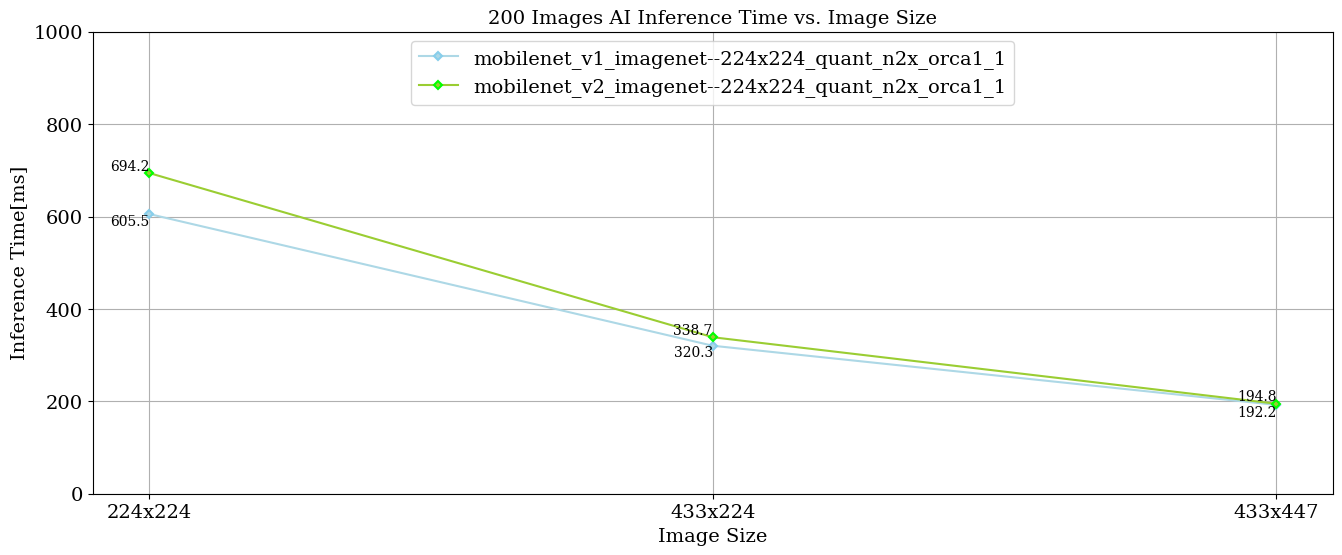

In [10]:
data_dir = '/home/gotom/data_dir/200pics_measure/'
label1 = 'mobilenet_v1_imagenet--224x224_quant_n2x_orca1_1'
label2 = 'mobilenet_v2_imagenet--224x224_quant_n2x_orca1_1'
graph_title = '200 Images AI Inference Time vs. Image Size'
y_max = 1000
suffix = time.strftime('%m%d%H%M')
draw_graph(data_dir, mobile_net_v1_durationD, mobile_net_v2_durationD, label1, label2, graph_title, y_max, suffix)